## Preprocessing

Before we begin training we have to:
 1. Turn our audio files into images
 2. Turn our string labels into binary indicator labels (similar to one-hot encoding)
 3. Perform label smoothing on the noisy dataset

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from fastai.vision import Path
import pandas as pd
import matplotlib.pyplot as plt 
import librosa
import librosa.display
from EasyDict import EasyDict
import IPython
import IPython.display
from tqdm import tqdm_notebook
from PIL import Image as pilImage
import os
import sklearn.metrics
from sklearn.preprocessing import MultiLabelBinarizer

In [30]:
DATA = Path('data')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_MERGED = DATA/'train_merged.csv'
CSV_TRN_SMOOTHED = DATA/'train_smoothed.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_MERGED = WORK/'image/trn_merged2'
IMG_TEST = WORK/'image/test2'
for folder in [WORK, IMG_TEST, IMG_TRN_MERGED]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

train_df = pd.read_csv(CSV_TRN_CURATED)
train_noisy_df = pd.read_csv(CSV_TRN_NOISY)
test_df = pd.read_csv(CSV_SUBMISSION)

In [31]:
#EDA Suggests this is a an error
train_df[train_df['fname'] == '77b925c2.wav']

,fname,labels
2316,77b925c2.wav,Stream


## Convert Audio to Spectrograms

So it seems like everyone is turning this audio classification class into an image classification task in which we look at visual representations of the sounds.

In [61]:
def read_audio(conf, pathname, trim_long_data):
    y, _ = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
        
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    elif len(y) * 2 > conf.samples:
        # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    else:
        y = np.pad(y, (1000,1000), 'constant')
        numRepeat = conf.samples // len(y)
        y = np.tile(y, numRepeat)
        #Pad the rest out
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def audio_to_cqt(conf, audio):
    spectrogram = librosa.cqt(audio, 
                              sr=conf.sampling_rate,
                              hop_length=conf.hop_length,
                              n_bins=120,
                              fmin=conf.fmin)
    
    #spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='mfcc'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                            sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

    
def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    print(mels.shape)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

def read_as_cqt(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    cqt = audio_to_cqt(conf, x)
    print(cqt.shape)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, cqt)
    return cqt


conf = EasyDict()
#conf.sampling_rate = 44100
#conf.duration = 5
#conf.hop_length = 347 # to make time steps 128
#conf.fmin = 20
#conf.fmax = conf.sampling_rate // 2
#conf.n_mels = 128
#conf.n_fft = conf.n_mels * 20

conf.sampling_rate = 44100            # Highest quality
conf.duration = 3                     # About double the length of time we look at
conf.hop_length = 512                 # We're looking at about 1.4 seconds
conf.fmin = 20                        # Near the lowest a human can hear
conf.fmax = conf.sampling_rate // 2   # The maximum frequency we can represent
conf.n_mels = 128                     # Our crops are 128 in height
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

(120, 259)


/home/josh/.local/lib/python3.6/site-packages/librosa/display.py:696: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


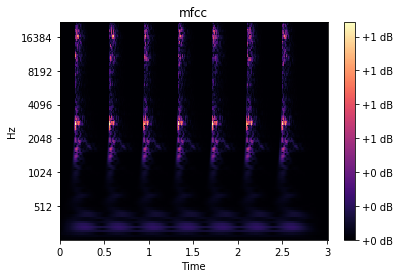

In [62]:
x = read_as_cqt(conf, TRN_CURATED/'fc3472cf.wav', trim_long_data=False, debug_display=True)

(128, 259)


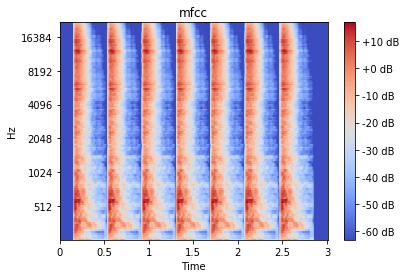

In [56]:
x = read_as_melspectrogram(conf, TRN_CURATED/'fc3472cf.wav', trim_long_data=False, debug_display=True)

In [20]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    #X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
        
    return V

def convert_wav_to_image(df, source, image_destinations):
    
    #Check whether the files already exist in the destination folder
    filename = str(df.iloc[0].fname) + ".jpg"
    
    for img_dest in image_destinations:
        if os.path.isfile(img_dest/filename):
            print("First image already exists. Skipping")
            return
    
    for i, row in tqdm_notebook(df.iterrows()):
        try:
            x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
            x_color = mono_to_color(x)
            img = pilImage.fromarray(x_color, mode='L')
            filename = str(row.fname) + ".jpg"
            
            for img_dest in image_destinations:
                img.save(img_dest/filename)
                
        except Exception as e: 
            print(e)

%time convert_wav_to_image(train_df, source=TRN_CURATED, image_destinations=[IMG_TRN_MERGED])
%time convert_wav_to_image(train_noisy_df, source=TRN_NOISY, image_destinations=[IMG_TRN_MERGED])
%time convert_wav_to_image(test_df, source=TEST, image_destinations=[IMG_TEST])


CPU times: user 15min 43s, sys: 13min 13s, total: 28min 56s
Wall time: 4min 20s



CPU times: user 1h 36min 2s, sys: 1h 18min 42s, total: 2h 54min 44s
Wall time: 26min 59s



CPU times: user 4min 9s, sys: 3min 28s, total: 7min 37s
Wall time: 1min 7s


## Binarizer

Right now the labels are formatted as strings. Let's instead make them binary indicators.

In [32]:
y_train = train_df['labels'].apply(lambda f: f.split(','))
y_noisy = train_noisy_df['labels'].apply(lambda f: f.split(','))
y_train[:5]

0               [Bark]
1           [Raindrop]
2    [Finger_snapping]
3                [Run]
4    [Finger_snapping]
Name: labels, dtype: object

In [33]:
binarizer = MultiLabelBinarizer()

y_train_binary = binarizer.fit_transform(y_train)
y_noisy_binary = binarizer.fit_transform(y_noisy)

print(len(binarizer.classes_))
print(binarizer.classes_)
print(y_train_binary[:5])

80
['Accelerating_and_revving_and_vroom' 'Accordion' 'Acoustic_guitar' 'Applause' ... 'Whispering' 'Writing' 'Yell'
 'Zipper_(clothing)']
[[0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]]


In [34]:
train_df = train_df.drop(columns=['labels'])
train_noisy_df = train_noisy_df.drop(columns=['labels'])

In [35]:
train_df = train_df.join(pd.DataFrame(y_train_binary))
train_noisy_df = train_noisy_df.join(pd.DataFrame(y_noisy_binary))
train_df.head()

,fname,0,1,2,3,4,5,6,7,8,...,70,71,72,73,74,75,76,77,78,79
0,0006ae4e.wav,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0019ef41.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ec0ad.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0026c7cb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0026f116.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's correct the column names using the binarizer.

In [36]:
#fname is the first column name, insert it at the start of the list
allColumnNames = np.insert(binarizer.classes_, 0, 'fname')

In [37]:
train_df.columns = allColumnNames
train_noisy_df.columns = allColumnNames
train_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,0006ae4e.wav,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0019ef41.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ec0ad.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0026c7cb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0026f116.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Label Smoothing

[Label smoothing](https://openreview.net/forum?id=BJlr0j0ctX) allows us to weaken the predictions of noisy labels. Instead of marking a sound as having a 100% chance of occuring in a given example, we'll reduce it to 90%. Instead of having all other sounds having a 0% chance of occuring in a given example, we'll increase it to 1%. 

The hope here is that we will weaken the effects of noisy labels.

**Note**: Most people don't implement label smoothing in this way and instead modify the loss function. However it's more convenient for us to modify the labels directly because:
 1. We're performing multi-label classification, so our probabilities don't sum to 1.
 2. We only wish to smooth labels on the noisy portion of our dataset

In [27]:
for column in train_df.columns[1:]:
    train_df[column] = train_df[column].apply(lambda x: 0.99 if x == 1 else 0.001)

In [28]:
train_df.to_csv(CSV_TRN_SMOOTHED, index=False)

In [38]:
for column in train_noisy_df.columns[1:]:
    train_noisy_df[column] = train_noisy_df[column].apply(lambda x: 0.9 if x == 1 else 0.01)

In [39]:
train_noisy_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,00097e21.wav,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.90,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,000b6cfb.wav,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,00116cd2.wav,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
3,00127d14.wav,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.90,0.01,0.01,0.01,0.01,0.01
4,0019adae.wav,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


## Merge the Datasets

In [40]:
#Merge the noisy and curated .csv's
print(train_df.head())
print(train_noisy_df.head())

train_merged = pd.concat([train_df, train_noisy_df])
train_merged.to_csv(CSV_TRN_MERGED, index=False)

          fname  Accelerating_and_revving_and_vroom  Accordion  \
0  0006ae4e.wav                                   0          0   
1  0019ef41.wav                                   0          0   
2  001ec0ad.wav                                   0          0   
3  0026c7cb.wav                                   0          0   
4  0026f116.wav                                   0          0   

   Acoustic_guitar  Applause  Bark  Bass_drum  Bass_guitar  \
0                0         0     1          0            0   
1                0         0     0          0            0   
2                0         0     0          0            0   
3                0         0     0          0            0   
4                0         0     0          0            0   

   Bathtub_(filling_or_washing)  Bicycle_bell  ...  Toilet_flush  \
0                             0             0  ...             0   
1                             0             0  ...             0   
2                         